In [1]:
import sys, os, datetime, json
sys.path.append("../")

import requests

from web3 import Web3, HTTPProvider

In [27]:
from json import JSONDecodeError

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
web3 = Web3(HTTPProvider(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}"))

In [20]:
with open("./abi/old_fsm.json", 'r') as f:
    abi = json.load(f)
old_fsm = web3.eth.contract(address="0xE6F5377DE93A361cd5531bdFbDf0f4b522E16B2B", abi=abi)

In [5]:
rai_graph_url = 'https://api.thegraph.com/subgraphs/name/reflexer-labs/rai-mainnet'

Utility functions provided by RAI team:

In [7]:
def fetch_collateral_price(block: int = 0):
    """

    :param url:
    :param block:
    :return:
    """
    query = '''
    query {{
        collateralPrices(first: 1, block: {{number: {}}}) {{
            collateral {{
              currentFsmUpdate {{
                value
              }}
            }}
        }}
    }}'''

    r = requests.post(rai_graph_url, json = {'query':query.format(block)})
    fsm_update = json.loads(r.content)['data']['collateralPrices'][0]['collateral']['currentFsmUpdate']['value']

    return float(fsm_update)

In [8]:
def fetch_safes(block: int = 0):
    """

    :param url:
    :param block:
    :return:
    """
    query = '''
    query {{
        safes(first: 1000, skip:{}, block: {{number: {}}}) {{
            safeId
            collateral
            debt
            collateralType {{
                liquidationCRatio
            }}
        }}
    }}'''

    n = 0
    safes = []
    while True:
        r = requests.post(rai_graph_url, json = {'query':query.format(n*1000, block)})
        s = json.loads(r.content)['data']['safes']
        safes.extend(s)
        n += 1
        if len(s) < 1000:
            break

    safes = pd.DataFrame(safes)
    safes['collateral'] = safes['collateral'].astype(float)
    safes['debt'] = safes['debt'].astype(float)

    return safes

In [9]:
def fetch_redemption_price(block: int):
    """

    :param url:
    :param block:
    :return:
    """
    query =  '''
    query {{
        systemStates(first:1, block: {{number: {}}}) {{
        currentRedemptionPrice {{
            value }}
        }}
    }}'''

    r = requests.post(rai_graph_url, json = {'query':query.format(block)})
    s = json.loads(r.content)['data']['systemStates'][0]['currentRedemptionPrice']['value']

    return float(s)

Plotting functions from RAI team for collateral ratio of RAI:

In [15]:
start_block = 11850000
old_fsm_block_end = 12380000
current_block = web3.eth.block_number
steps = 1000
old_fsm_blocks = range(start_block, old_fsm_block_end, steps)
len(old_fsm_blocks)

530

In [38]:
if not os.path.exists('./data/old_fsm.csv'):
    old_fsm_data = []
    for block_number in old_fsm_blocks:
        try:
            price, is_valid = old_fsm.caller(block_identifier=block_number).getResultWithValidity()
            block_timestamp = web3.eth.getBlock(block_number)['timestamp']
            block_time = datetime.datetime.fromtimestamp(block_timestamp)
        except Exception as e:
            print(e)
            continue

        if is_valid:
            old_fsm_data.append(
                {
                    'block_number': block_number,
                    'block_timestamp': block_timestamp,
                    'block_time': block_time,
                    'price': price * 1e-18
                }
            )
    df_old_fsm = pd.DataFrame(old_fsm_data)
    df_old_fsm.set_index('block_time', inplace=True)
    df_old_fsm.to_csv('./data/old_fsm.csv')
else:
    df_old_fsm = pd.read_csv('./data/old_fsm.csv', index_col=[0])
df_old_fsm

,block_number,block_timestamp,price
block_time,,,
2021-02-13 19:49:58,11850000,1613242198,1803.656430
2021-02-13 23:39:12,11851000,1613255952,1803.656430
2021-02-14 03:11:12,11852000,1613268672,1803.656430
2021-02-14 06:39:51,11853000,1613281191,1803.656430
2021-02-14 10:28:03,11854000,1613294883,1803.656430
...,...,...,...
2021-05-05 17:25:09,12375000,1620228309,3355.820670
2021-05-05 21:02:12,12376000,1620241332,3438.986672
2021-05-06 00:36:26,12377000,1620254186,3466.470000


Get Global Collateral Ratio:

In [22]:
collateral_ratio_blocks = range(start_block, current_block, steps)
len(collateral_ratio_blocks)

1923

In [59]:
if not os.path.exists('./historic_global_collateral_ratio_and_liquidation_ratio.csv'):

    global_collateral_ratio_data = []
    for block in collateral_ratio_blocks:

        block_timestamp = web3.eth.getBlock(block)['timestamp']
        block_time = datetime.datetime.fromtimestamp(block_timestamp)

        # fetch collateral price:
        if block < old_fsm_block_end:
            fsm_price = df_old_fsm.where(df_old_fsm.block_number == block).dropna()['price'].values[0]
        else:
            # to avoid JSONDecodeError, need to do a loop:
            while True:
                try:
                    fsm_price = fetch_collateral_price(block)
                    break
                except JSONDecodeError:
                    print(f'retrying fetch_collateral_price for block {block}')
                    continue

        # fetch redemption price
        while True:
            try:
                redemption_price = fetch_redemption_price(block)
                break
            except JSONDecodeError:
                print(f'retrying fetch_redemption_price for block {block}')
                continue

        # fetch safes
        while True:
            try:
                safes = fetch_safes(block)
                break
            except JSONDecodeError:
                print(f'retrying fetch_safes for block {block}')
                continue

        safes['liquidation_ratio'] = [float(r[1]['liquidationCRatio']) for r in safes.values]
        number_of_safes = safes.shape[0]

        # get liquidation_ratio
        liquidation_ratio = safes['liquidation_ratio'].iat[0]

        # global c-ratio
        total_collateral_eth = safes['collateral'].sum()
        total_debt_rai = safes['debt'].sum()
        total_collateral_usd = total_collateral_eth * fsm_price
        total_debt_usd = total_debt_rai * redemption_price
        global_c_ratio = total_collateral_usd / total_debt_usd

        global_collateral_ratio_data.append(
            {
                'block_number': block,
                'block_time': block_time,
                'block_timestamp': block_timestamp,
                'number_of_safes': number_of_safes,
                'fsm_price': fsm_price,
                'total_collateral_eth': total_collateral_eth,
                'total_debt_rai': total_debt_rai,
                'redemption_price': redemption_price,
                'total_collateral_usd': total_collateral_usd,
                'total_debt_usd': total_debt_usd,
                'liquidation_ratio': liquidation_ratio,
                'global_collateral_ratio': global_c_ratio
            }
        )

    df_collateral_ratio = pd.DataFrame(global_collateral_ratio_data)
    df_collateral_ratio.to_csv('./data/historic_global_collateral_ratio_and_liquidation_ratio.csv')

else:

    df_collateral_ratio = pd.read_csv('./data/historic_global_collateral_ratio_and_liquidation_ratio.csv', index_col=[0])

df_collateral_ratio

retrying fetch_collateral_price for block 13354000
retrying fetch_safes for block 13355000


,block_number,block_time,block_timestamp,number_of_safes,fsm_price,total_collateral_eth,total_debt_rai,redemption_price,total_collateral_usd,total_debt_usd,liquidation_ratio,global_collateral_ratio
0,11850000,2021-02-13 19:49:58,1613242198,2,1803.656430,5.292360,8.000000e+02,3.140000,9.545600e+03,2.512000e+03,1.45,3.800000
1,11851000,2021-02-13 23:39:12,1613255952,2,1803.656430,5.292360,8.000000e+02,3.140000,9.545600e+03,2.512000e+03,1.45,3.800000
2,11852000,2021-02-14 03:11:12,1613268672,2,1803.656430,5.292360,8.000000e+02,3.140000,9.545600e+03,2.512000e+03,1.45,3.800000
3,11853000,2021-02-14 06:39:51,1613281191,2,1803.656430,5.292360,8.000000e+02,3.140000,9.545600e+03,2.512000e+03,1.45,3.800000
4,11854000,2021-02-14 10:28:03,1613294883,3,1803.656430,9.292360,1.988440e+03,3.140000,1.676023e+04,6.243703e+03,1.45,2.684341
...,...,...,...,...,...,...,...,...,...,...,...,...
1918,13768000,2021-12-09 01:47:38,1639010858,2234,4301.460000,51530.304179,2.775687e+07,3.031312,2.216555e+08,8.413971e+07,1.35,2.634375
1919,13769000,2021-12-09 05:38:14,1639024694,2235,4301.460000,51540.304179,2.775885e+07,3.031312,2.216986e+08,8.414573e+07,1.35,2.634698
1920,13770000,2021-12-09 09:22:59,1639038179,2235,4421.849344,51540.304179,2.775885e+07,3.031420,2.279035e+08,8.414875e+07,1.35,2.708341
1921,13771000,2021-12-09 13:17:03,1639052223,2235,4421.849344,51543.804179,2.776422e+07,3.031420,2.279189e+08,8.416501e+07,1.35,2.708001


In [69]:
df_collateral_ratio.set_index('block_time', inplace=True)

Plot Global Collateral Ratio and Liquidation Ratio:

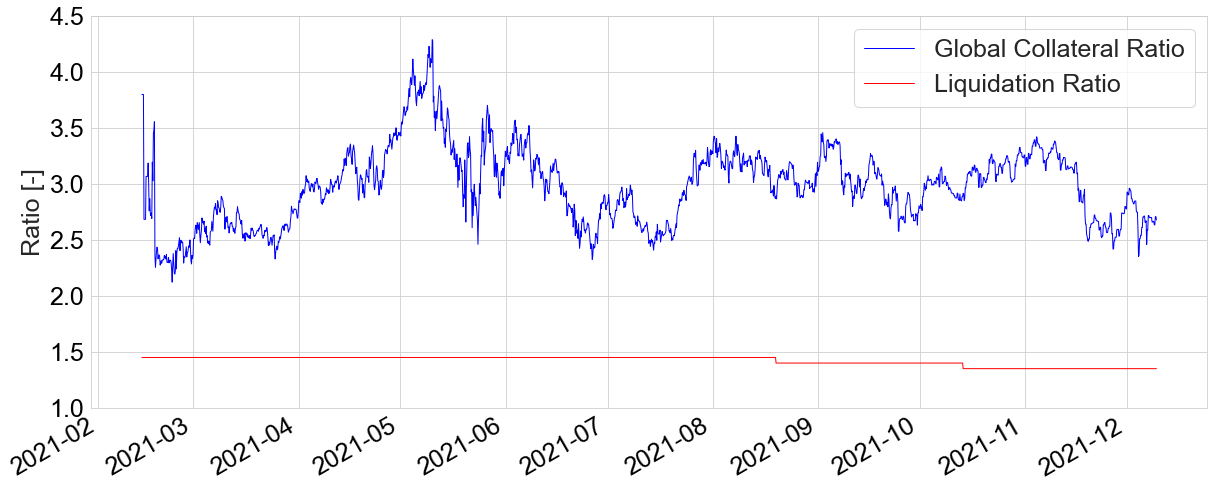

In [71]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

df_collateral_ratio['global_collateral_ratio'].plot(
    ax=ax,
    color='blue',
    label='Global Collateral Ratio',
    lw=1,
)

df_collateral_ratio['liquidation_ratio'].plot(
    ax=ax,
    color='red',
    label='Liquidation Ratio',
    lw=1,
)

ax.set_ylabel("Ratio [-]", fontsize=25)
ax.set_xlabel("")
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.legend(fontsize=25)
ax.set_ylim([1, 4.5]);

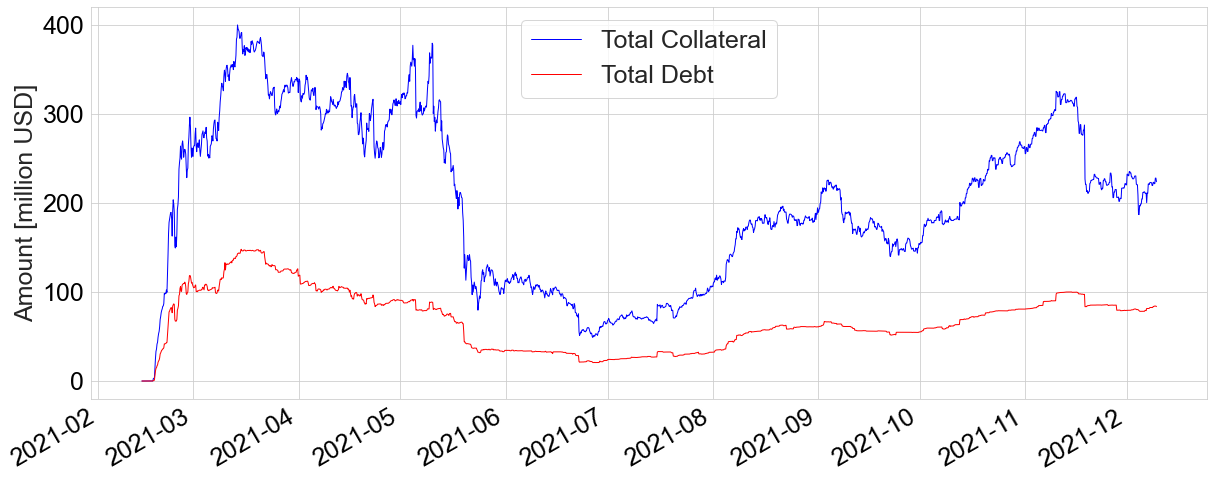

In [72]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

(df_collateral_ratio['total_collateral_usd']*1e-6).plot(
    ax=ax,
    color='blue',
    label='Total Collateral',
    lw=1,
)

(df_collateral_ratio['total_debt_usd']*1e-6).plot(
    ax=ax,
    color='red',
    label='Total Debt',
    lw=1,
)

ax.set_ylabel("Amount [million USD]", fontsize=25)
ax.set_xlabel("")
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.legend(fontsize=25);

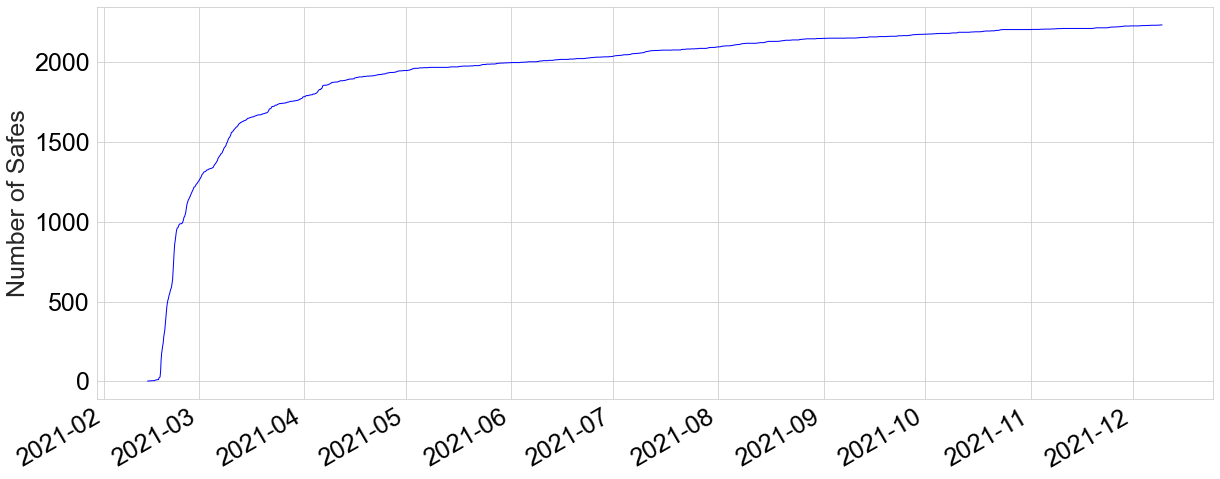

In [73]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

df_collateral_ratio['number_of_safes'].plot(
    ax=ax,
    color='blue',
    lw=1,
)

ax.set_ylabel("Number of Safes", fontsize=25)
ax.set_xlabel("")
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False);